In [1]:
import pandas as pd

# Load the dataset
file_path = "nonoilgdp_2024.csv"
data = pd.read_csv(file_path)

# Check the column names and the first few rows
print("Columns in the dataset:", data.columns)
print(data.head())


Columns in the dataset: Index(['Years', 'Non-Oil GDP Growth'], dtype='object')
   Years  Non-Oil GDP Growth
0   1974                38.7
1   1975                26.6
2   1976                 4.2
3   1977                 4.4
4   1978                 9.7


In [2]:
data = data.rename(columns={"Years": "ds", "Non-Oil GDP Growth": "y"})

In [3]:
data.head(5)

,ds,y
0,1974,38.7
1,1975,26.6
2,1976,4.2
3,1977,4.4
4,1978,9.7


In [4]:
# Rename columns to match Prophet's requirements
data = data.rename(columns={"date": "ds", "Non-Oil GDP Growth": "y"})

# Convert 'ds' to datetime format
data["ds"] = pd.to_datetime(data["ds"], format='%Y')

# Add time-based features
data["day_of_week"] = data["ds"].dt.dayofweek
data["day_of_year"] = data["ds"].dt.dayofyear
data["month"] = data["ds"].dt.month
data["quarter"] = data["ds"].dt.quarter

# Display first few rows to confirm changes
print(data.head())


          ds     y  day_of_week  day_of_year  month  quarter
0 1974-01-01  38.7            1            1      1        1
1 1975-01-01  26.6            2            1      1        1
2 1976-01-01   4.2            3            1      1        1
3 1977-01-01   4.4            5            1      1        1
4 1978-01-01   9.7            6            1      1        1


In [5]:
from prophet import Prophet


c:\Users\MoaviaHassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [6]:
# Initialize the Prophet model
model = Prophet()

# Fit the model on the dataset
model.fit(data[["ds", "y"]])

# Display the training progress
print("Model trained successfully.")


12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:19 - cmdstanpy - INFO - Chain [1] done processing


Model trained successfully.


In [7]:
# Create a dataframe for future dates (next 5 years)
future = model.make_future_dataframe(periods=5, freq="YE")

# Forecast future values
forecast = model.predict(future)

# Display the forecasted values
print(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(10))


           ds      yhat  yhat_lower  yhat_upper
45 2019-01-01  3.028403   -5.257788   11.307499
46 2020-01-01  2.324863   -5.768482   10.361564
47 2021-01-01  3.051832   -5.257136   11.673374
48 2022-01-01  2.980698   -5.539717   11.079861
49 2023-01-01  2.593188   -5.523456   10.870353
50 2023-12-31 -3.623522  -11.564784    4.826874
51 2024-12-31  0.870971   -7.829113    9.597033
52 2025-12-31 -0.461400   -9.411175    7.711993
53 2026-12-31 -2.105478  -10.402801    6.533509
54 2027-12-31 -4.058737  -12.507905    4.066371


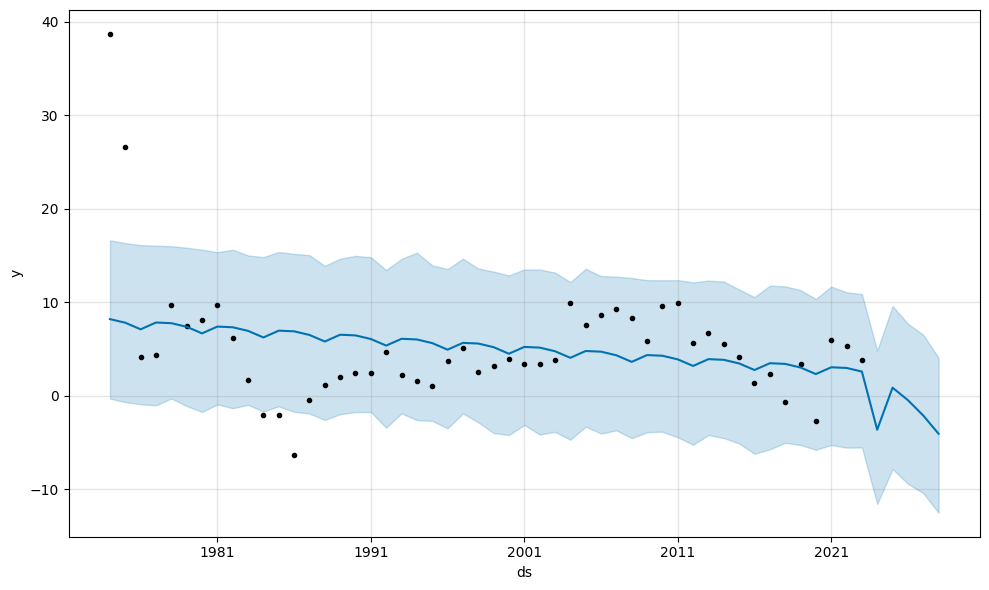

In [8]:
# Plot the forecast
fig = model.plot(forecast)


In [9]:
from sklearn.metrics import mean_absolute_error, r2_score

# Merge the actual and forecasted values for historical data
merged = data.merge(forecast, on="ds", how="left")

# Calculate errors
mae = mean_absolute_error(merged["y"], merged["yhat"])
mape = (abs(merged["y"] - merged["yhat"]) / merged["y"]).mean() * 100
r2 = r2_score(merged["y"], merged["yhat"])

# Print evaluation metrics
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"R²: {r2}")


MAE: 4.181562107173425
MAPE: 10.460423280057912%
R²: 0.06422030211993168


In [10]:
# Add seasonality to the Prophet model
model = Prophet(yearly_seasonality=True)  # Enable yearly seasonality

# Fit the model again
model.fit(data[["ds", "y"]])


12:01:31 - cmdstanpy - INFO - Chain [1] start processing
12:01:32 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet import Prophet

# Grid of parameters to search
param_grid = {
    "changepoint_prior_scale": [0.01, 0.1, 0.5, 1.0, 10.0, 100.0],
    "seasonality_prior_scale": [0.1, 1.0, 10.0, 100.0],
}

# Store the results
best_params = None
best_mae = float("inf")

# Iterate over all combinations
for changepoint_prior in param_grid["changepoint_prior_scale"]:
    for seasonality_prior in param_grid["seasonality_prior_scale"]:
        # Initialize the model
        model = Prophet(
            changepoint_prior_scale=changepoint_prior,
            seasonality_prior_scale=seasonality_prior,
            yearly_seasonality=True
        )

        # Fit the model
        model.fit(data[["ds", "y"]])

        # Cross-validation to evaluate performance
        df_cv = cross_validation(
            model,
            horizon="3650 days",  # 10 years
            period="1825 days",  # 5 years
            initial="7300 days"  # 20 years
        )
        df_p = performance_metrics(df_cv)

        # Check if this combination is better
        if df_p["mae"].mean() < best_mae:
            best_mae = df_p["mae"].mean()
            best_params = {
                "changepoint_prior_scale": changepoint_prior,
                "seasonality_prior_scale": seasonality_prior,
            }

# Print the best parameters
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")


12:01:32 - cmdstanpy - INFO - Chain [1] start processing
12:01:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]12:01:33 - cmdstanpy - INFO - Chain [1] start processing
12:01:33 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  2.11it/s]12:01:33 - cmdstanpy - INFO - Chain [1] start processing
12:01:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:00<00:00,  2.27it/s]12:01:33 - cmdstanpy - INFO - Chain [1] start processing
12:01:34 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  2.19it/s]12:01:34 - cmdstanpy - INFO - Chain [1] start processing
12:01:34 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
12:01:34 - cmdstanpy - INFO - Chain [1] start processing
12:01:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]12:01:35 - cmdstanpy - INFO - Chain [1] start processing
12:01:35 -

Best Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}
Best MAE: 4.436124070582279


12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing


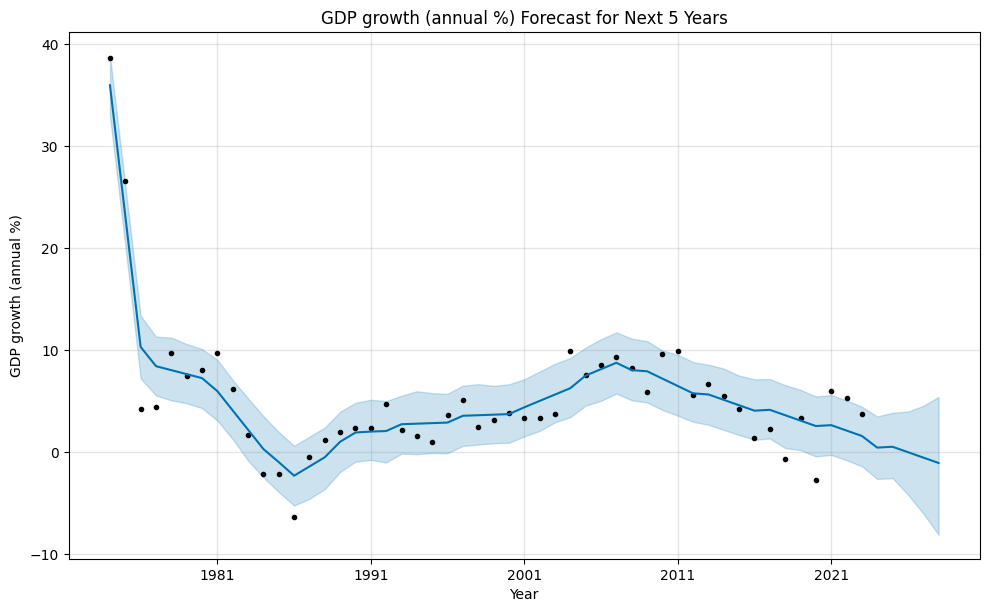

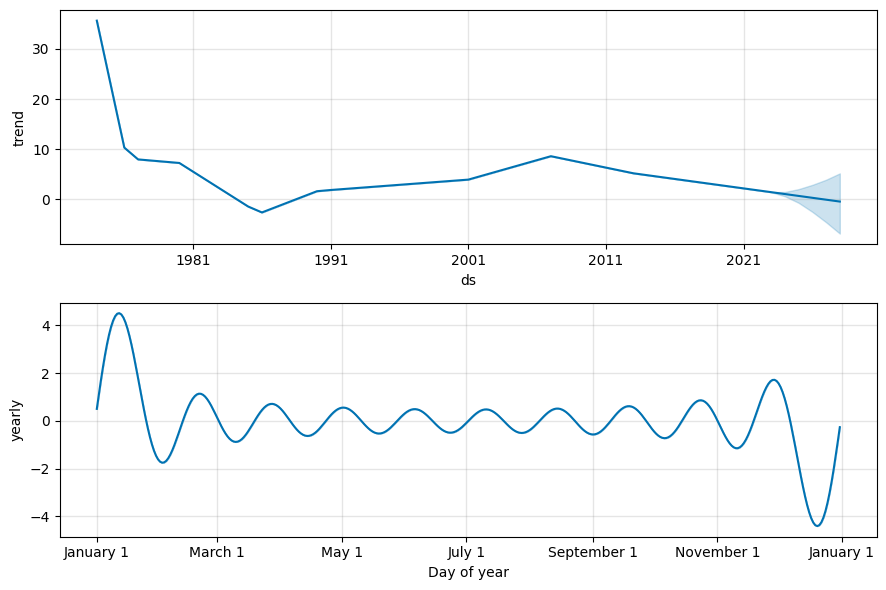

In [12]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Best parameters from grid search
best_params = {
    "changepoint_prior_scale": 1.5,  # Update with the best value from grid search
    "seasonality_prior_scale": 0.1  # Update with the best value from grid search
}

# Train the final model
final_model = Prophet(
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
    yearly_seasonality=True
)

# Fit the model
final_model.fit(data[["ds", "y"]])

# Create a future dataframe for the next 10 years
future = final_model.make_future_dataframe(periods=5, freq="YE")

# Forecast future values
forecast = final_model.predict(future)

# Plot the forecast
fig = final_model.plot(forecast)
plt.title("GDP growth (annual %) Forecast for Next 5 Years")
plt.xlabel("Year")
plt.ylabel("GDP growth (annual %)")
plt.show()

# Plot components (trend, yearly seasonality, etc.)
fig2 = final_model.plot_components(forecast)
plt.show()


In [13]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Extract predictions for the historical period
forecast_history = forecast[forecast["ds"] <= data["ds"].max()]

# Compute evaluation metrics
mae = mean_absolute_error(data["y"], forecast_history["yhat"])
mape = mean_absolute_percentage_error(data["y"], forecast_history["yhat"]) * 100
r2 = r2_score(data["y"], forecast_history["yhat"])

print(f"Final Model MAE: {mae}")
print(f"Final Model MAPE: {mape:.2f}%")
print(f"Final Model R²: {r2}")


Final Model MAE: 1.798065864549921
Final Model MAPE: 61.16%
Final Model R²: 0.8822102754106496


In [14]:
# Extract only future forecasts
future_forecast = forecast[forecast["ds"] > data["ds"].max()]

# Display future predictions
print(future_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]])


           ds      yhat  yhat_lower  yhat_upper
50 2023-12-31  0.460522   -2.609564    3.512974
51 2024-12-31  0.542644   -2.533881    3.879486
52 2025-12-31  0.013246   -4.143971    3.992955
53 2026-12-31 -0.515760   -5.994673    4.555830
54 2027-12-31 -1.044190   -8.087288    5.428298


In [15]:
# Extract future forecast values into an array
future_forecast = forecast[forecast["ds"] > data["ds"].max()]
forecast_array = future_forecast["yhat"].values

# Display forecast values
print("Forecasted GDP growth (annual %) (Next 5 Years):")
print(forecast_array)


Forecasted GDP growth (annual %) (Next 5 Years):
[ 0.46052181  0.54264425  0.01324638 -0.51576028 -1.04418966]


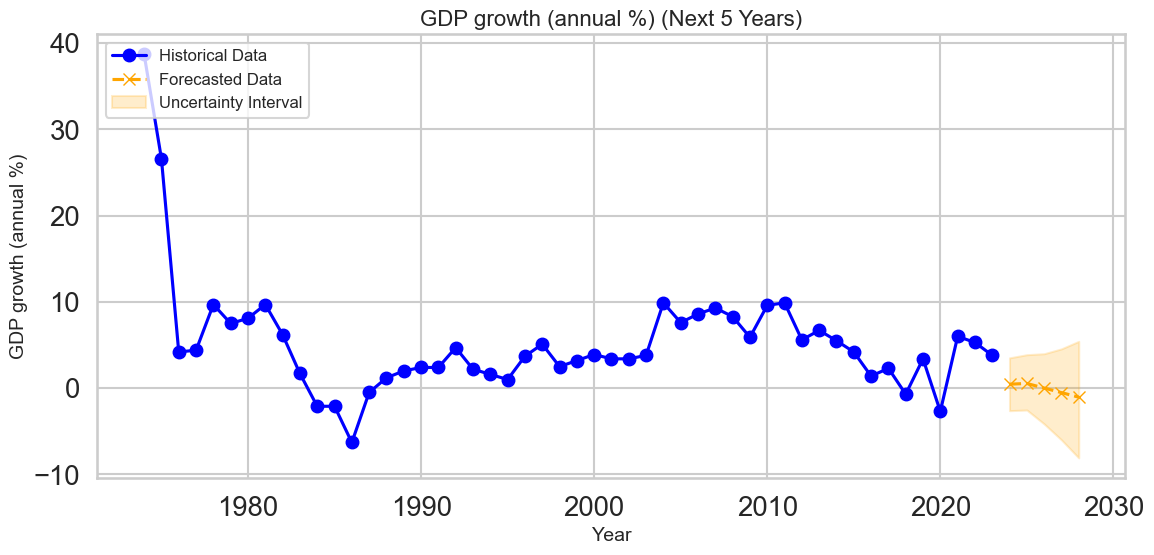

In [16]:
import seaborn as sns
sns.set(style="whitegrid", context="talk", font_scale=1.2)

# Plot the historical data and future forecast
plt.figure(figsize=(12, 6))
plt.plot(data["ds"], data["y"], label="Historical Data", color="blue", marker="o")
plt.plot(future_forecast["ds"], future_forecast["yhat"], label="Forecasted Data", color="orange", linestyle="--", marker="x")
plt.fill_between(
    future_forecast["ds"],
    future_forecast["yhat_lower"],
    future_forecast["yhat_upper"],
    color="orange",
    alpha=0.2,
    label="Uncertainty Interval"
)

# Customize the graph
plt.title("GDP growth (annual %) (Next 5 Years)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("GDP growth (annual %)", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()
plt.savefig("forecast_line_graph.png", dpi=300)  # Save as PNG for publication
plt.show()


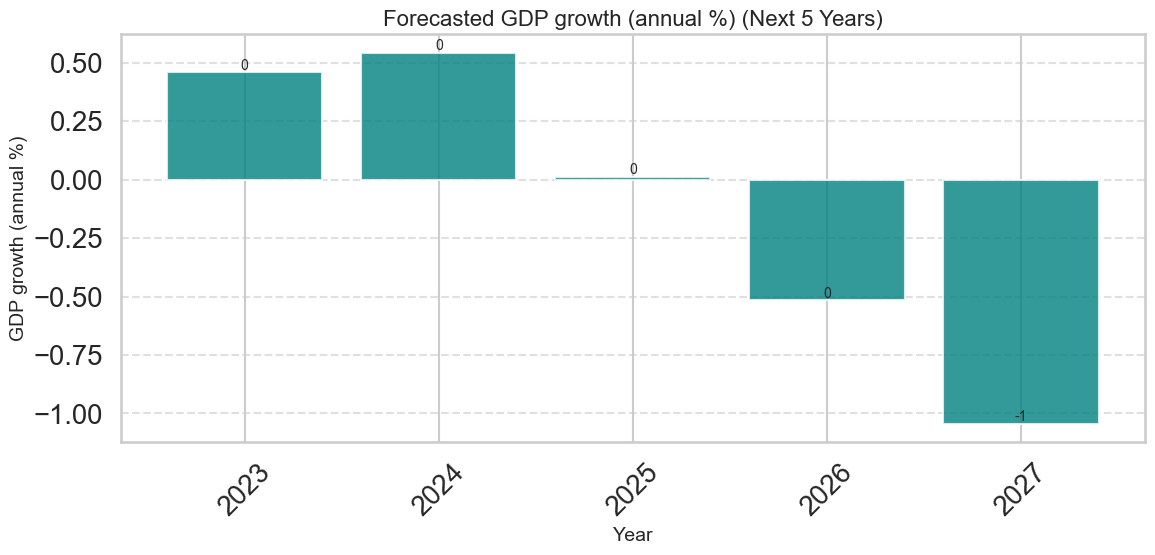

In [17]:
# Bar chart for forecasted values
plt.figure(figsize=(12, 6))
plt.bar(future_forecast["ds"].dt.year, forecast_array, color="teal", alpha=0.8)

# Customize the graph
plt.title("Forecasted GDP growth (annual %) (Next 5 Years)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("GDP growth (annual %)", fontsize=14)
plt.xticks(future_forecast["ds"].dt.year, rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add value annotations on the bars
for index, value in enumerate(forecast_array):
    plt.text(
        x=future_forecast["ds"].dt.year.iloc[index],
        y=value + 0.02 * max(forecast_array),
        s=f"{int(value)}",
        ha="center",
        fontsize=10
    )

plt.tight_layout()
plt.savefig("forecast_bar_chart.png", dpi=300)  # Save as PNG for publication
plt.show()


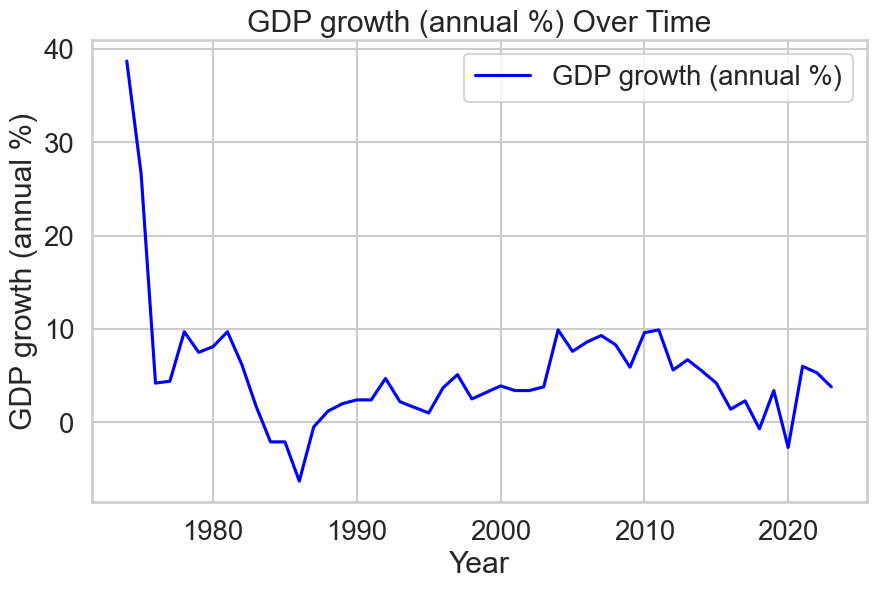

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data["ds"], data["y"], label="GDP growth (annual %)", color="blue")
plt.title("GDP growth (annual %) Over Time")
plt.xlabel("Year")
plt.ylabel("GDP growth (annual %)")
plt.grid(True)
plt.legend()
plt.show()


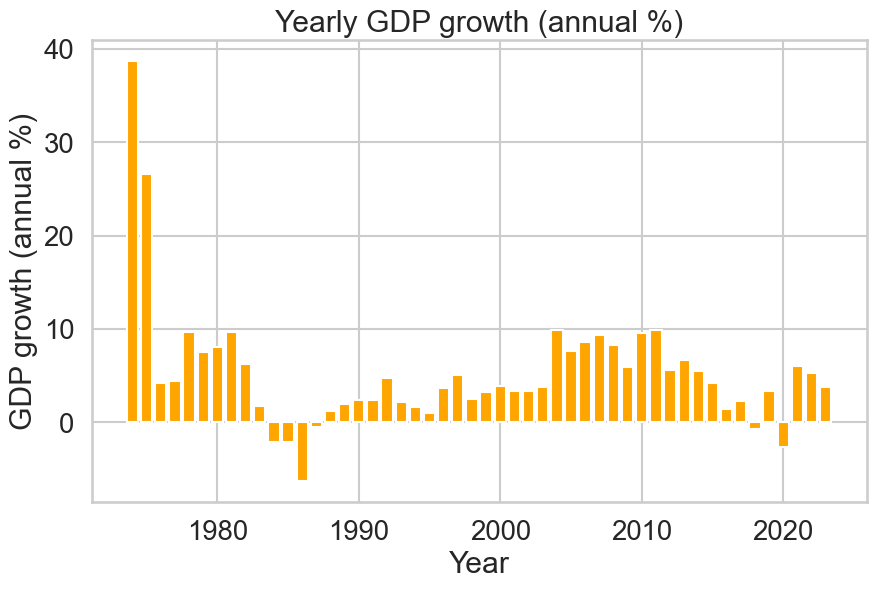

In [19]:
plt.figure(figsize=(10, 6))
plt.bar(data["ds"].dt.year, data["y"], color="orange")
plt.title("Yearly GDP growth (annual %)")
plt.xlabel("Year")
plt.ylabel("GDP growth (annual %)")
plt.show()


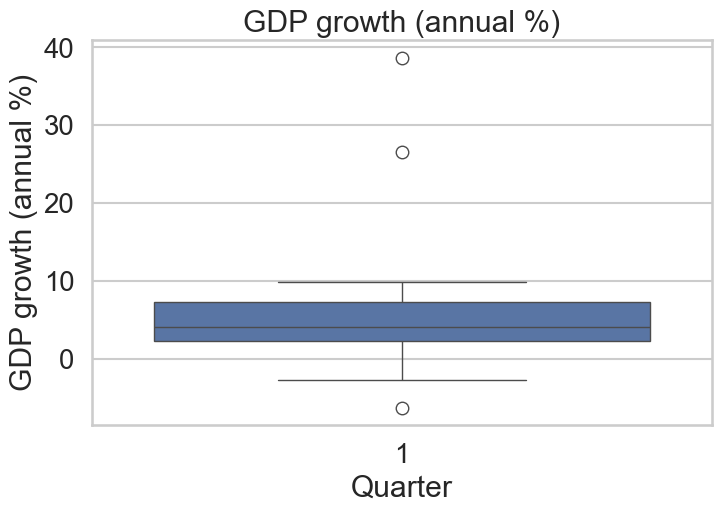

In [20]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(x="quarter", y="y", data=data)
plt.title("GDP growth (annual %)")
plt.xlabel("Quarter")
plt.ylabel("GDP growth (annual %)")
plt.show()


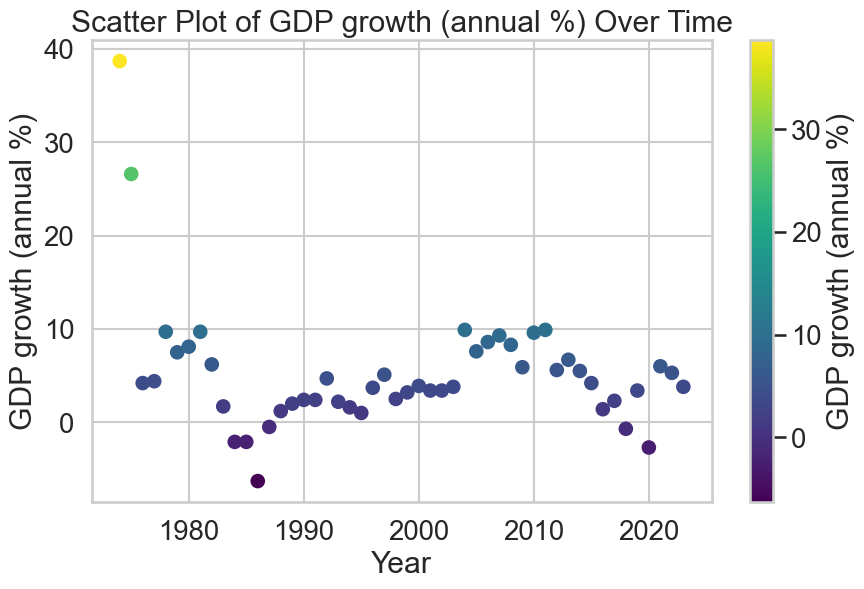

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(data["ds"], data["y"], c=data["y"], cmap="viridis")
plt.title("Scatter Plot of GDP growth (annual %) Over Time")
plt.xlabel("Year")
plt.ylabel("GDP growth (annual %)")
plt.colorbar(label="GDP growth (annual %)")
plt.show()


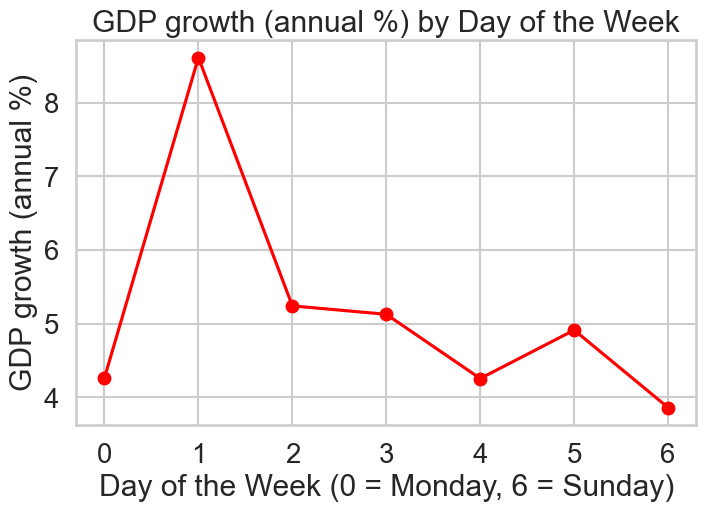

In [22]:
day_of_week_data = data.groupby("day_of_week")["y"].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.plot(day_of_week_data["day_of_week"], day_of_week_data["y"], marker="o", linestyle="-", color="red")
plt.title("GDP growth (annual %) by Day of the Week")
plt.xlabel("Day of the Week (0 = Monday, 6 = Sunday)")
plt.ylabel("GDP growth (annual %)")
plt.grid(True)
plt.show()
